L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `GaussianLinearCalibration`.

On considère ici un modèle *exactement* linéaire. On considère de plus une sortie bi-dimensionnelle. On essaye de calculer l'estimateur MAP par une décomposition de Cholesky puis de calculer la matrice de covariance.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
inVars = ["x", "theta1", "theta2", "theta3"]
formulas = ["theta1 + theta2*x + theta3*x^2", "theta1 + theta2*sin(x) + theta3*sin(2*x)"]
g = ot.SymbolicFunction(inVars, formulas)
g

class=SymbolicFunction name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x,theta1,theta2,theta3,y0,y1] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1 + theta2*x + theta3*x^2,theta1 + theta2*sin(x) + theta3*sin(2*x)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1 + theta2*x + theta3*x^2,theta1 + theta2*sin(x) + theta3*sin(2*x)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1 + theta2*x + theta3*x^2,theta1 + theta2*sin(x) + theta3*sin(2*x)]

In [4]:
descr = ["Theta1", "Theta2", "Theta3"]

In [5]:
trueParameter = ot.Point([11.11,6.6,-9.9])
trueParameter

class=Point name=Unnamed dimension=3 values=[11.11,6.6,-9.9]

In [6]:
parameterDimension = trueParameter.getDimension()
parameterDimension

3

Create the joint input distribution function.

In [7]:
X = ot.Uniform()
Theta1 = ot.Dirac(trueParameter[0])
Theta2 = ot.Dirac(trueParameter[1])
Theta3 = ot.Dirac(trueParameter[2])

X.setDescription(["X"])
Theta1.setDescription(["Theta1"])
Theta2.setDescription(["Theta2"])
Theta3.setDescription(["Theta3"])

inputRandomVector = ot.ComposedDistribution([X, Theta1, Theta2, Theta3])

In [8]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, trueParameter)

Generate observation noise.

In [9]:
observationOutputNoise = ot.Normal([0.0]*2, [0.5]*2, ot.IdentityMatrix(2))
observationOutputNoise

class=Normal name=Normal dimension=2 mean=class=Point name=Unnamed dimension=2 values=[0,0] sigma=class=Point name=Unnamed dimension=2 values=[0.5,0.5] correlationMatrix=class=CorrelationMatrix dimension=2 implementation=class=MatrixImplementation name=Unnamed rows=2 columns=2 values=[1,0,0,1]

## Gaussian linear calibration

Define the covariance matrix of the output Y of the model.

In [10]:
errorCovariance = ot.CovarianceMatrix(2)
for i in range(2):
    errorCovariance[i, i] = 2.0 + (1.0 + i) * (1.0 + i)
    for j in range(i):
        errorCovariance[i, j] = 1.0 / (1.0 + i + j)
errorCovariance

class=CovarianceMatrix dimension=2 implementation=class=MatrixImplementation name=Unnamed rows=2 columns=2 values=[3,0.5,0.5,6]

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [11]:
sigmaTheta1 = 0.1 * trueParameter[0]
sigmaTheta2 = 0.1 * trueParameter[1]
sigmaTheta3 = 0.1 * trueParameter[2]

In [12]:
parameterCovariance = ot.CovarianceMatrix(3)
parameterCovariance[0,0] = sigmaTheta1**2
parameterCovariance[1,1] = sigmaTheta2**2
parameterCovariance[2,2] = sigmaTheta3**2
parameterCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1.23432,0,0,0,0.4356,0,0,0,0.9801]

In [13]:
size = 10

In [14]:
# 1. Generate exact outputs
inputSample = inputRandomVector.getSample(size)
outputStress = g(inputSample)
# 2. Add noise
sampleNoiseH = observationOutputNoise.getSample(size)
outputObservations = outputStress + sampleNoiseH
outputObservations

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=2 description=[y0,y1] data=[[12.3314,7.71278],[11.0787,6.19674],[1.4245,16.3142],[-3.58518,14.1148],[7.5234,14.1524],[8.53482,7.49585],[9.58518,5.91247],[11.3725,11.1912],[-1.98803,15.2776],[6.24523,15.9875]]

In [15]:
inputObservations = inputSample[:,0]

In [16]:
candidate = ot.Point([12.,7.,-8])
candidate

class=Point name=Unnamed dimension=3 values=[12,7,-8]

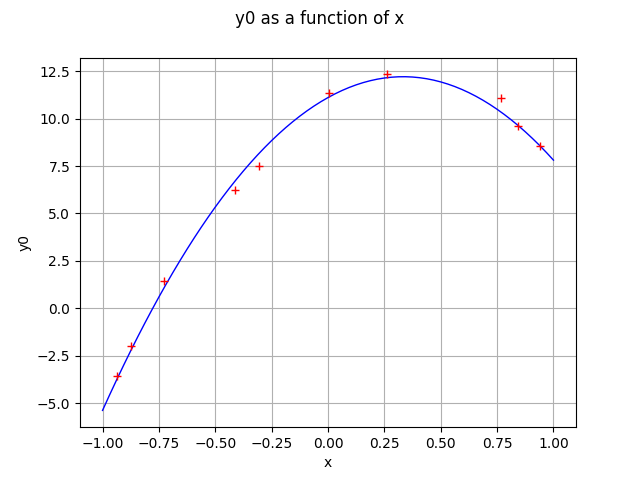

In [17]:
graph = model.getMarginal(0).draw(-1,1)
cloud = ot.Cloud(inputObservations,outputObservations[:,0])
cloud.setColor("red")
graph.add(cloud)
graph

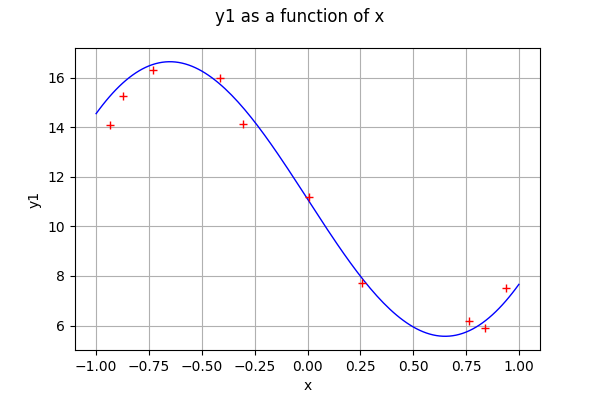

In [18]:
graph = model.getMarginal(1).draw(-1,1)
cloud = ot.Cloud(inputObservations,outputObservations[:,1])
cloud.setColor("red")
graph.add(cloud)
graph

## Analysis of the results

In [19]:
def GaussianLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance):
    '''Use GaussianLinearCalibration'''
    algo = ot.GaussianLinearCalibration(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)
    algo.run()
    calibrationResult = algo.getResult()
    thetaStar = calibrationResult.getParameterMAP()
    thetaPosterior = calibrationResult.getParameterPosterior()
    covarianceThetaStar = thetaPosterior.getCovariance()
    return thetaStar, covarianceThetaStar

In [20]:
def GaussianNonLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance):
    '''Use GaussianNonLinearCalibration'''
    algo = ot.GaussianNonLinearCalibration(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)
    algo.run()
    calibrationResult = algo.getResult()
    thetaStar = calibrationResult.getParameterMAP()
    thetaPosterior = calibrationResult.getParameterPosterior()
    covarianceThetaStar = thetaPosterior.getCovariance()
    return thetaStar, covarianceThetaStar

## Calibration based on Kalman matrix

In [21]:
def ComputeFromKalman(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance):
    '''Compute the solution from the Kalman matrix'''
    parameterDimension = candidate.getDimension()
    size = inputObservations.getSize()
    # Compute model observations
    model.setParameter(candidate)
    modelObservations = model(inputObservations)
    # Compute residuals
    residuals = outputObservations - modelObservations
    outputDimension = modelObservations.getDimension()
    # Stack the residuals by observation, 
    #   deltay = [residuals[i,0],residuals[i,1],...,residuals[i,outputDimension]]
    deltay = ot.Point(size*outputDimension)
    for i in range(size):
        for j in range(outputDimension):
            deltay[i*outputDimension + j] = residuals[i,j]
    # Compute J
    transposedGradientObservations = ot.Matrix(parameterDimension,size*outputDimension)
    for i in range(size):
        g = model.parameterGradient(inputObservations[i])
        for j in range(outputDimension):
            for k in range(parameterDimension):
                transposedGradientObservations[k,i*outputDimension + j] = g[k,j]
    gradientObservations = transposedGradientObservations.transpose()
    # Compute R
    observationDimension = errorCovariance.getDimension()
    R = ot.CovarianceMatrix(deltay.getSize())
    for i in range(size):
        for j in range(observationDimension):
            for k in range(observationDimension):
                R[i * observationDimension + j, i * observationDimension + k] = errorCovariance[j,k]
    # Compute B, inverse of B
    B = ot.CovarianceMatrix(parameterCovariance)
    IB = ot.IdentityMatrix(parameterDimension)
    invB = B.solveLinearSystem(IB)
    # Compute inverse of R
    IR = ot.IdentityMatrix(R.getNbRows())
    invR = R.solveLinearSystem(IR)
    #
    C = gradientObservations.transpose() * invR
    invA = invB + C * gradientObservations
    K = invA.solveLinearSystem(C)
    print("Cond(Kalman)=",np.linalg.cond(K))
    thetaStar = candidate + K * deltay
    #
    L = IB - K * gradientObservations
    covarianceThetaStar = K * R * K.transpose() + L * B * L.transpose()
    return thetaStar, covarianceThetaStar

In [22]:
def ComputeFromLinearLeastSquaresCholesky(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance):
    parameterDimension = candidate.getDimension()
    size = inputObservations.getSize()
    # Compute model observations
    model.setParameter(candidate)
    modelObservations = model(inputObservations)
    # Compute residuals
    residuals = outputObservations - modelObservations
    outputDimension = modelObservations.getDimension()
    # Stack the residuals by observation, 
    #   deltay = [residuals[i,0],residuals[i,1],...,residuals[i,outputDimension]]
    deltay = ot.Point(size*outputDimension)
    for i in range(size):
        for j in range(outputDimension):
            deltay[i*outputDimension + j] = residuals[i,j]
    # Compute J
    transposedGradientObservations = ot.Matrix(parameterDimension,size*outputDimension)
    for i in range(size):
        g = model.parameterGradient(inputObservations[i])
        for j in range(outputDimension):
            for k in range(parameterDimension):
                transposedGradientObservations[k,i*outputDimension + j] = g[k,j]
    gradientObservations = transposedGradientObservations.transpose()
    # Compute R
    observationDimension = errorCovariance.getDimension()
    R = ot.CovarianceMatrix(deltay.getSize())
    for i in range(size):
        for j in range(observationDimension):
            for k in range(observationDimension):
                R[i * observationDimension + j, i * observationDimension + k] = errorCovariance[j,k]
    # Create B, R, inv(B), inv(R)
    B = ot.CovarianceMatrix(parameterCovariance)
    LB = B.computeCholesky()
    LR = R.computeCholesky()
    #
    ILB = ot.IdentityMatrix(parameterDimension)
    invLB = LB.solveLinearSystem(ILB)
    invLRJ = LR.solveLinearSystem(gradientObservations)
    # Compute Abar
    Abar = ot.Matrix(parameterDimension+size*outputDimension,parameterDimension)
    Abar[0:parameterDimension,0:parameterDimension] = invLB
    for i in range(size):
        for j in range(outputDimension):
            for k in range(parameterDimension):
                Abar[i*outputDimension + j + parameterDimension,k] = -invLRJ[i*outputDimension + j,k]
    #
    invLRz = LR.solveLinearSystem(deltay)
    # Compute ybar
    ybar = ot.Point(parameterDimension+size*outputDimension)
    for i in range(size):
        for j in range(outputDimension):
            ybar[i*outputDimension + j + parameterDimension] = -invLRz[i*outputDimension + j]
    # Solve the least squares problem
    print("Cond(Linear Least Squares/Cholesky)=",np.linalg.cond(Abar))
    method = ot.SVDMethod(Abar)
    deltaTheta = method.solve(ybar)
    thetaStar = deltaTheta + candidate
    covarianceThetaStar = method.getGramInverse()
    return thetaStar, covarianceThetaStar

## GaussianLinearCalibrationCompute

In [23]:
thetaStar, covarianceThetaStar = GaussianLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)

In [24]:
thetaStar

class=Point name=Unnamed dimension=3 values=[11.0496,6.77479,-9.11727]

In [25]:
covarianceThetaStar

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.21174,0.0238928,-0.0905,0.0238928,0.244571,-0.0584876,-0.0905,-0.0584876,0.350896]

## GaussianNonLinearCalibrationCompute

In [26]:
thetaStar, covarianceThetaStar = GaussianNonLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)

In [27]:
thetaStar

class=Point name=Unnamed dimension=3 values=[11.0496,6.77479,-9.11727]

In [28]:
covarianceThetaStar

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0092047,0.000858401,-0.00138761,0.000858401,0.00506538,0.00181057,-0.00138761,0.00181057,0.00678218]

## Kalman

In [29]:
thetaStar, covarianceThetaStar = ComputeFromKalman(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance)
thetaStar

Cond(Kalman)= 1.4286936311480014


class=Point name=Unnamed dimension=3 values=[11.0496,6.77479,-9.11727]

In [30]:
covarianceThetaStar

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.21174,0.0238928,-0.0905,0.0238928,0.244571,-0.0584876,-0.0905,-0.0584876,0.350896]

## From the extended linear least squares

In [31]:
thetaStar, covarianceThetaStar = ComputeFromLinearLeastSquaresCholesky(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance)
thetaStar

Cond(Linear Least Squares/Cholesky)= 1.5834868565778306


class=Point name=Unnamed dimension=3 values=[11.0496,6.77479,-9.11727]

In [32]:
covarianceThetaStar

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.21174,0.0238928,-0.0905,0.0238928,0.244571,-0.0584876,-0.0905,-0.0584876,0.350896]